### Load stuff

In [1]:
import torch
from torchvision.transforms import Normalize
from torchvision.utils import save_image
from torchvision.utils import make_grid
from gan_model import UpsampleGenerator, Discriminator, Generator
from vae_model import VAE
import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
latent_dimension = 100

In [4]:
re_norm = Normalize([-1, -1, -1], [2, 2, 2])

In [5]:
# load the generator
gan_checkpoint = '../upsample/checkpoint_{}.pth'.format(99)
gan_model = UpsampleGenerator(latent_dimension).to(device)
checkpoint = torch.load(gan_checkpoint, map_location=device)
gan_model.load_state_dict(checkpoint['gen_model'])
gan_model.eval()

UpsampleGenerator(
  (network): Sequential(
    (0): Upsample(scale_factor=4, mode=bilinear)
    (1): Conv2d(100, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
    (4): Upsample(scale_factor=2, mode=bilinear)
    (5): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace)
    (8): Upsample(scale_factor=2, mode=bilinear)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): Upsample(scale_factor=2, mode=bilinear)
    (13): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): Tanh()
  )
)

In [6]:
# load VAE
vae_checkpoint = '../vae/upsample_checkpoint_132.pth'
vae_model = VAE(latent_dimension).to(device)
checkpoint = torch.load(vae_checkpoint, map_location=device)
vae_model.load_state_dict(checkpoint['model'])
vae_model.eval()

VAE(
  (encoder): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.2, inplace)
      (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.2, inplace)
      (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.2, inplace)
    )
  )
  (lin1): Sequential(
    (0): Linear(in_features=2048, out_features=100, bias=True)
    (1): ReLU()
  )
  (fc11): Linear(in_features=100, out_features=100, bias=True)
  (fc12): Linear(in_features=100, out_features=100, bias=True)
  (decoder): UpsampleGenerator(
    (network): Sequential(
      (0): Upsample(scale_factor=4, mode=bilinear)
      (1): Conv2d(100, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [12]:
def show_grid(imgs, nrow, file, figsize=(6.4, 4.8)):
    plt.figure(figsize=figsize)
    imgs = copy.deepcopy(imgs)
    for i in range(len(imgs)):
        imgs[i] = re_norm(imgs[i])
    im = make_grid(imgs, nrow=nrow, padding=1)
    plt.imshow(im.permute(1,2,0))
    plt.show()
    save_image(im, file)

# Qualitative evaluation

### Part 1 
Comment, compare, and contrast the quality of the samples from
each model (e.g. blurriness, diversity).

In [173]:
# generate visual samples
z = torch.randn(1000, latent_dimension, device=device)
with torch.no_grad():
    vae_out = vae_model.decoder(z)
    gan_out = gan_model(z).detach()
for i , im in enumerate(vae_out):
    save_image(re_norm(im), 'vae/samples/sample_{}.png'.format(i))
for i , im in enumerate(gan_out):
    save_image(re_norm(im), 'gan/samples/sample_{}.png'.format(i))

### Part 2
We want to see if the model has learned a disentangled representation in the
latent space. Sample a random z from your prior distribution. Make small perturbations
to your sample z for each dimension (e.g. for a dimension i, z i 0 = z i + ).  has to be large
enough to see some visual difference. For each dimension, observe if the changes result in
visual variations (that means variations in g(z)). You do not have to show all dimensions,
just a couple that result in interesting changes.

In [139]:
# perturbing dimension
def pertube(z, epsilon, steps, dim):
#     epsilon_m = torch.Tensor([epsilon*i for i in range(int(-steps/2), int(steps/2))])
    new_z = copy.deepcopy(z)
    new_z[:, dim] += epsilon
    return new_z

In [151]:
z = torch.randn(1, latent_dimension, device=device)

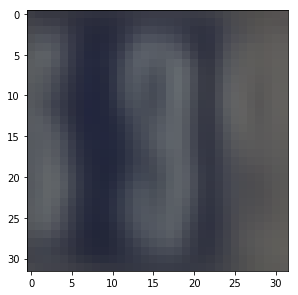

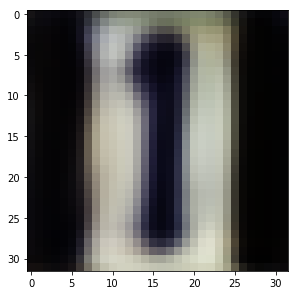

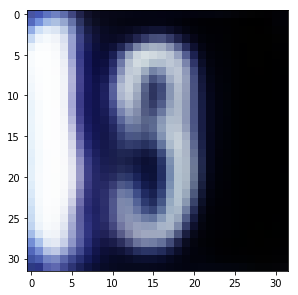

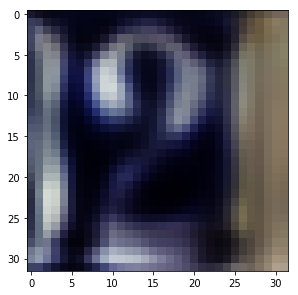

In [154]:
pbs = 1
with torch.no_grad():
    vae_orig = vae_model.decoder(z)
show_grid(vae_orig, 16, 'report/vae_2_orig.png')
# for i in range(latent_dimension):
#     print(i)
#     new_z = pertube(z, 10, pbs, i)
#     with torch.no_grad():
#         out = vae_model.decoder(new_z)
#         show_grid(out, 16, 'report/vae_temp.png')
new_z = pertube(z, 10, pbs, 58)
with torch.no_grad():
    vae_out = vae_model.decoder(new_z)
show_grid(vae_out, 16, 'report/vae_2_1.png')
new_z = pertube(z, 10, pbs, 95)
with torch.no_grad():
    vae_out = vae_model.decoder(new_z)
show_grid(vae_out, 16, 'report/vae_2_2.png')
new_z = pertube(z, 10, pbs, 85)
with torch.no_grad():
    vae_out = vae_model.decoder(new_z)
show_grid(vae_out, 16, 'report/vae_2_3.png')

In [165]:
z = torch.randn(1, latent_dimension, device=device)

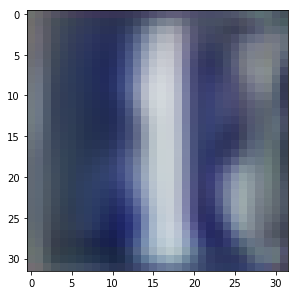

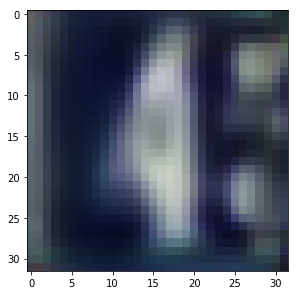

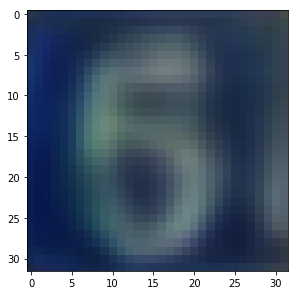

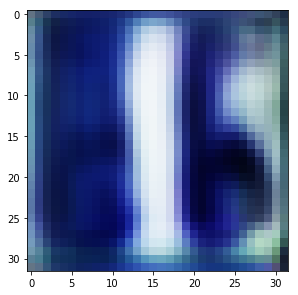

In [172]:
with torch.no_grad():
    gan_orig = gan_model(z)
show_grid(gan_orig, 16, 'report/gan_2_orig.png')
# for i in range(latent_dimension):
#     print(i)
#     new_z = pertube(z, 5, pbs, i)
#     with torch.no_grad():
#         out = gan_model(new_z)
#         show_grid(out, 16, 'report/gan_temp.png')

new_z = pertube(z, 5, pbs, 8)
with torch.no_grad():
    gan_out = gan_model(new_z).detach()
show_grid(gan_out, 16, 'report/gan_2_1.png')
new_z = pertube(z, 5, pbs, 28)
with torch.no_grad():
    gan_out = gan_model(new_z).detach()
show_grid(gan_out, 16, 'report/gan_2_2.png')
new_z = pertube(z, 5, pbs, 58)
with torch.no_grad():
    gan_out = gan_model(new_z).detach()
show_grid(gan_out, 16, 'report/gan_2_3.png')

### Part 3
Compare between interpolating in the data space and in the latent space. Pick
two random points z 0 and z 1 in the latent space sampled from the prior.

- For α = 0, 0.1, 0.2 ... 1 compute z α 0 = αz 0 + (1 − α)z 1 and plot the resulting samples x 0 α = g(z α 0 ).
- Using the data samples x 0 = g(z 0 ) and x 1 = g(z 1 ) and for α = 0, 0.1, 0.2 ... 1 plot the samples x̂ α = αx 0 + (1 − α)x 1 . 

Explain the difference with the two schemes to interpolate between images.

In [128]:
z = torch.randn(2, latent_dimension, device=device)
z_alpha = [(alpha/10*z[0] + (1-alpha/10)*z[1]).unsqueeze(0) for alpha in range(0, 11)]
z_alpha = torch.cat(z_alpha, dim=0)
assert z_alpha.shape == (11, latent_dimension)

In [129]:
with torch.no_grad():
    vae_x_alpha = vae_model.decoder(z_alpha)
    gan_x_alpha = gan_model(z_alpha)

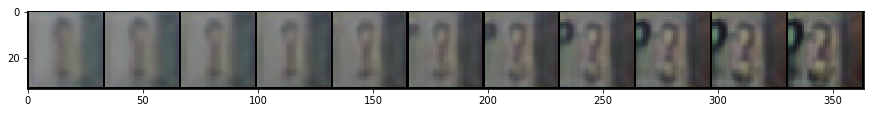

In [130]:
# show_grid(vae_x_alpha, 11, 'report/vae_3_a.png', figsize=(15,15))
show_grid(gan_x_alpha, 11, 'report/gan_3_a.png', figsize=(15,15))

In [131]:
def get_x_hat(gen, z):
    with torch.no_grad():
        x = gen(z)
    x_hat = [(alpha/10*x[0] + (1-alpha/10)*x[1]).unsqueeze(0) for alpha in range(0, 11)]
    return torch.cat(x_hat)

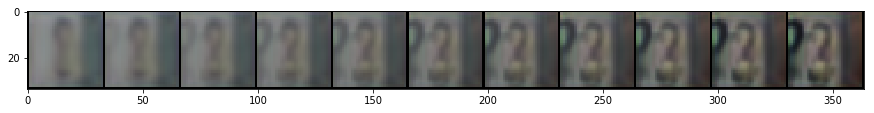

In [132]:
vae_x_hat = get_x_hat(vae_model.decoder, z)
gan_x_hat = get_x_hat(gan_model, z)
# show_grid(vae_x_hat, 11, 'report/vae_3_b.png', figsize=(15,15))
show_grid(gan_x_hat, 11, 'report/gan_3_b.png',figsize=(15,15))